In [1]:
from pathlib import Path
import glob, sys, os
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from p_tqdm import p_map
import seaborn as sns
sns.set_context('poster')
import matplotlib as mpl

In [2]:
# region = 'USA.10.367' # palm beach
# region = 'IND.10.121.371' # delhi
# region = 'USA.44.2535' # austin texas
# region = 'USA.18.1030' # fulton (atlanta)
region = 'USA.3.101' # maricopa (phoenix)
delta_var = 'summed_delta'
histclim_var = 'summed_histclim'
year = 2095
ssp = 'SSP3'
model ='IIASA GDP'
rcp = 'rcp85'

In [3]:
# data paths
damages = '/shares/gcp/integration/float32/sectoral_ir_damages/AMEL_data/2021_10_13_AMEL.zarr'
gdppc = '/shares/gcp/integration/float32/dscim_input_data/econvars/zarrs/integration-econ.zarr'


# open and select relevant data
selection = dict(year=year, model=model, ssp=ssp, region=region)
delta = xr.open_zarr(damages).sel(**selection, rcp=rcp)[delta_var]
histclim = xr.open_zarr(damages).sel(**selection, rcp=rcp)[histclim_var]
gdppc = xr.open_zarr(gdppc).sel(selection).gdppc.values.item()
raw = delta.to_dataframe().reset_index()


# text specs
text_specs = dict(
    fontsize=15,
    xycoords='axes fraction'
)

# palette = ["#0077a0", "#fd1115"]
palette = ['mediumslateblue', 'mediumseagreen', 'coral']

In [4]:
def ce_func(consumption, dims, eta=2):
    """Calculate CRRA function"""
    return ((consumption ** (1 - eta) / (1 - eta)).mean(dims) * (1 - eta)) ** (
        1 / (1 - eta)
    )

In [5]:
no_cc = ce_func(gdppc - histclim,  ['batch', 'gcm']).values.item()
cc = ce_func(gdppc - delta, ['batch', 'gcm']).values.item()

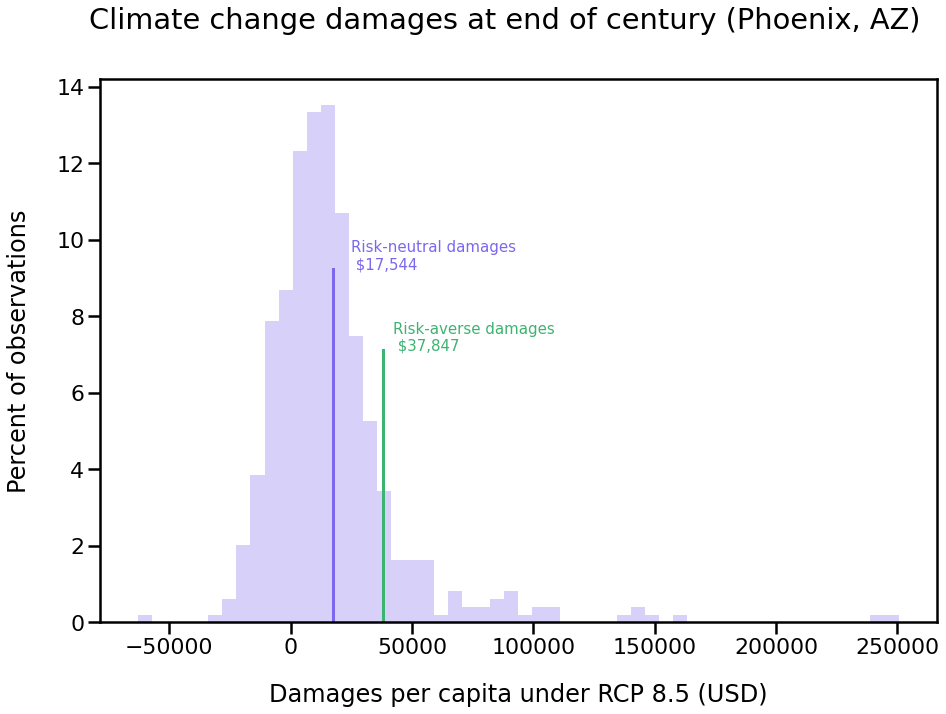

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

sns.histplot(raw,
             x=delta_var,
             stat='percent',
             color=palette[0],
             edgecolor=None,
             alpha=0.3,
             ax=ax
            )

mean = raw[delta_var].mean()
ce = no_cc - cc
plt.axvline(mean, 0, 0.65, color=palette[0])
plt.axvline(ce, 0, 0.5, color=palette[1])

plt.annotate(f'Risk-neutral damages \n ${"{:,}".format(int(mean))}', (0.3, 0.65),
             color=palette[0],
             **text_specs
            )

plt.annotate(f'Risk-averse damages \n ${"{:,}".format(int(ce))}', (0.35, 0.5),
             color=palette[1],
             **text_specs
            )
plt.ylabel('Percent of observations', labelpad=25)
plt.xlabel('Damages per capita under RCP 8.5 (USD)', labelpad=25)
fig.suptitle('Climate change damages at end of century (Phoenix, AZ)')

plt.savefig('/mnt/CIL_integration/explainer_plots/fig_1b.pdf', bbox_inches='tight')
plt.savefig('/mnt/CIL_integration/explainer_plots/fig_1b.png', bbox_inches='tight', dpi=300)